Available splits: dict_keys(['train', 'test'])
Dataset loaded and preprocessed successfully!
Training started...
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.9866 - loss: 0.0388 - val_accuracy: 0.9969 - val_loss: 0.0076
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


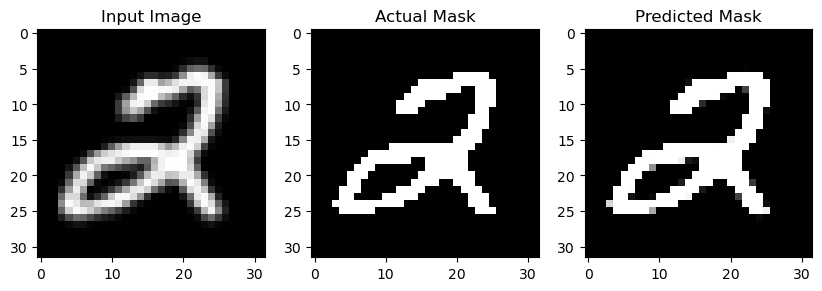

In [2]:

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the MNIST dataset
dataset, info = tfds.load("mnist", with_info=True, as_supervised=True)

print("Available splits:", dataset.keys())  # Should print ['train', 'test']

# Preprocessing function (convert to segmentation format)
def normalize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (32, 32)) / 255.0  # Resize to 32x32 for faster training
    input_mask = tf.where(input_image > 0.5, 1, 0)  # Convert image to binary mask
    return input_image, input_mask

def load_image(image, label):  # Ignore label since MNIST is normally classification
    return normalize(tf.cast(image, tf.float32), tf.cast(image, tf.uint8))

# Prepare dataset with a smaller batch size and resized images
train_data = dataset['train'].map(load_image).shuffle(1000).batch(8)  # Reduced batch size to 8
test_data = dataset['test'].map(load_image).batch(8)

print("Dataset loaded and preprocessed successfully!")

# Define a very simple CNN model (further reduced complexity)
def simple_cnn():
    inputs = tf.keras.layers.Input(shape=(32, 32, 1))  # Adjusted for 32x32 input

    # A very simple CNN with fewer filters
    conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder (use transpose convolution for upsampling)
    up4 = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(conv3)
    concat4 = tf.keras.layers.Concatenate()([up4, conv2])

    up5 = tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu')(concat4)
    concat5 = tf.keras.layers.Concatenate()([up5, conv1])

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(concat5)  # Binary segmentation

    model = tf.keras.Model(inputs, outputs)
    return model

# Compile model
model = simple_cnn()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model with fewer epochs for faster results
print("Training started...")
model.fit(train_data, epochs=1, validation_data=test_data)  # Reduced to 1 epoch for faster results

# Predict and visualize
def display_sample(dataset):
    for image, mask in dataset.take(1):
        pred_mask = model.predict(image)
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image[0, :, :, 0], cmap='gray')
        plt.title("Input Image")

        plt.subplot(1, 3, 2)
        plt.imshow(mask[0, :, :, 0], cmap='gray')
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[0, :, :, 0], cmap='gray')
        plt.title("Predicted Mask")

        plt.show()
        break

# Visualize results
display_sample(test_data)

